# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
!pip install JSAnimation

# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
game_name = 'SpaceInvadersDeterministic-v4'
#env = gym.make('PongDeterministic-v4')
env = gym.make(game_name)

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



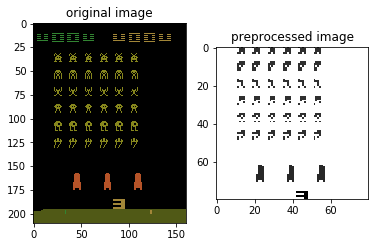

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        ########
        ## 
        ## Modify your neural network
        ##
        ########
        
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        
        ########
        ## 
        ## Modify your neural network
        ##
        ########
    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

# run your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress

In [5]:
pong_utils.play(env, policy, time=600) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [6]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ##
    ########
    #print("rewards: {}".format(rewards)) 
    
    #calculate future rewards
    future_rewards = []
    for i in range(len(rewards)):
        this_reward = np.zeros(rewards[0].shape)
        for ii in range(i, len(rewards)):
            this_reward += rewards[ii]*discount**(ii-i)
        future_rewards.append(this_reward)
    #print("future_rewards: {}".format(future_rewards))    
    
    #normalize the rewards
    mean = np.mean(future_rewards, axis=1)
    #print("mean: {}".format(mean))
    std = np.std(future_rewards, axis=1) + 1.0e-10
    #print("std: {}".format(std))
    future_rewards_normalized_np = (future_rewards - mean[:,np.newaxis])/std[:,np.newaxis]

    #convert to tensors
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    future_rewards_normalized_tensor = torch.tensor(future_rewards_normalized_np, dtype=torch.float, device=device)
    #print("future_rewards_normalized: {}".format(future_rewards_normalized))
    
    # convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)

    ratio = new_probs/old_probs
    ratio_clipped = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    ratio_ppo = torch.min(ratio,ratio_clipped)
    
#     print("ratio.shape: {}".format(ratio.shape))
#     print("ratio_clipped.shape: {}".format(ratio_clipped.shape))
#     print("ratio_ppo.shape: {}".format(ratio_ppo.shape))
    
#     print("ratio[:5]: {}".format(ratio[:5]))
#     print("ratio_clipped[:5]: {}".format(ratio_clipped[:5]))
#     print("ratio_ppo[:5]: {}".format(ratio_ppo[:5]))
    
    # include a regularization term
    # this steers new_policy towards 0.5
    # which prevents policy to become exactly 0 or 1
    # this helps with exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+(1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
    
    return torch.mean(ratio_ppo*future_rewards_normalized_tensor + beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [7]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv(game_name, n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 600
SGD_epoch = 9

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

#         L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
#                                           epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

Episode: 20, score: 201.875000
[195. 230. 455. 195.  80. 190. 140. 130.]


Episode: 40, score: 94.375000
[105. 105.  75. 105. 105.  50. 105. 105.]


Episode: 60, score: 83.125000
[ 45. 130.  85. 130.  85.  65.  75.  50.]


Episode: 80, score: 81.250000
[ 45.  90.  55. 130.  50.  60.  90. 130.]


Episode: 100, score: 101.250000
[ 45.  70. 140. 125. 125.  85.  65. 155.]


Episode: 120, score: 186.875000
[155.  75. 105. 105. 360. 410. 105. 180.]


Episode: 140, score: 175.625000
[100. 120. 110. 155. 125. 185. 410. 200.]


Episode: 160, score: 78.750000
[ 65.  60. 125. 100. 120.  45.  95.  20.]


Episode: 180, score: 171.875000
[135. 140. 165. 150. 195. 240. 180. 170.]


Episode: 200, score: 106.250000
[100.  30. 125. 125. 105. 105. 155. 105.]


Episode: 220, score: 98.750000
[ 65. 125.  75.  95. 135. 120. 115.  60.]


Episode: 240, score: 94.375000
[ 50. 105. 140.  80. 105.  55. 150.  70.]


Episode: 260, score: 120.000000
[115. 140. 115. 135. 120. 100.  45. 190.]


Episode: 280, score: 173.750000
[220. 135. 200. 150. 190. 185. 125. 185.]


Episode: 300, score: 185.000000
[135. 210. 170. 410. 135. 155. 165. 100.]


Episode: 320, score: 93.750000
[160.  65. 135. 145.  90.  55.  25.  75.]


Episode: 340, score: 94.375000
[105.  80. 110.  60. 140.  45. 115. 100.]


Episode: 360, score: 107.500000
[105. 110. 140. 130. 170.  70.  60.  75.]


Episode: 380, score: 109.375000
[110.  70. 295. 120.  55.  90.  85.  50.]


Episode: 400, score: 64.375000
[100. 100.  45.  60.  15.  65.  95.  35.]


Episode: 420, score: 98.750000
[ 45.  70. 100. 160. 110. 130.  50. 125.]


Episode: 440, score: 79.375000
[ 60. 125.  85.  70.  70. 110.  35.  80.]


Episode: 460, score: 65.625000
[ 50. 100.  80.  55.  30. 130.  30.  50.]


Episode: 480, score: 105.000000
[105. 105. 105. 105. 105. 105. 105. 105.]


Episode: 500, score: 105.000000
[105. 105. 105. 105. 105. 105. 105. 105.]


In [12]:
pong_utils.play(env, policy, time=2000) 

In [8]:
# save your policy!
torch.save(policy, 'PPO_{}.policy'.format(game_name))

# load policy if needed
# policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
# policy_solution = torch.load('PPO_solution.policy')
# pong_utils.play(env, policy_solution, time=2000) 